In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow
from datetime import datetime, timedelta

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Viz and mapping modules
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

In [5]:
#re-load pre-cleaned data
df = pd.read_parquet("../data/cta_crimes.parquet")
rid = pd.read_parquet("../data/cta_riders_month.parquet") 


In [6]:
#-- helpers --
def choose_k_for_spatial(X, k_candidates=None, sample_size=10000, random_state=42):
    # Subsample for silhouette if large
    rng = np.random.default_rng(random_state)
    if X.shape[0] > sample_size:
        idx = rng.choice(X.shape[0], size=sample_size, replace=False)
        Xs = X[idx]
    else:
        Xs = X

    # Heuristic candidates if none provided
    if k_candidates is None:
        # Use a coarse grid scaled by sqrt(n)
        n = Xs.shape[0]
        base = max(8, int(np.sqrt(max(50, n)) // 2) * 2)  # even-ish
        k_candidates = sorted(set([8, 12, 16, 20, 24, 32, 40, 48, base, base+8, base+16]))
        k_candidates = [k for k in k_candidates if 2 < k < min(250, n-1)]

    best_k, best_score = None, -1
    scores = []
    for k in k_candidates:
        try:
            km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
            labels = km.fit_predict(Xs)
            sc = silhouette_score(Xs, labels)
            scores.append((k, sc))
            if sc > best_score:
                best_k, best_score = k, sc
        except Exception:
            continue
    if best_k is None:
        best_k = 24  # fallback
    return best_k, scores

def plot_silhouette(scores):
    if not scores:
        return
    ks = [k for k, _ in scores]
    vals = [v for _, v in scores]
    plt.figure()
    plt.plot(ks, vals, marker="o")
    plt.title("Silhouette score by K (spatial clustering)")
    plt.xlabel("K (clusters)")
    plt.ylabel("Silhouette score")
    plt.grid(True)
    plt.show()

def mode_or_first(s):
    try:
        return s.mode(dropna=True).iloc[0]
    except Exception:
        return s.iloc[0]

def severity_weight_col(df,iucr_c,cat_c):
    # Prefer numeric IUCR severity if present
    if iucr_c is not None and pd.api.types.is_numeric_dtype(df[iucr_c]):
        raw = df[iucr_c].astype(float)
        # Normalize to [0.5, 1.0]
        lo, hi = raw.min(), raw.max()
        norm = (raw - lo) / (hi - lo + 1e-9)
        return 0.5 + 0.5 * norm

    # Else map crime_category
    if cat_c is not None:
        weights = df[cat_c].astype(str).str.upper().map({"VIOLENT": 1.0, "PETTY": 0.6})
        return weights.fillna(0.8)  # neutral
    # Fallback neutral weights
    return pd.Series(1.0, index=df.index)

def to_xy(lat, lon):
    # Rough lon scaling by cos(latitude) so degrees ~ comparable in both axes
    lat_rad = np.radians(np.nanmean(lat))
    x = lon * np.cos(lat_rad)
    y = lat
    return np.column_stack([x, y])

def build_hotspot_map(hotspots_df, tier_col="risk_tier"):
    if hotspots_df.empty:
        raise ValueError("No hotspots to map.")
    mlat, mlon = hotspots_df["lat"].median(), hotspots_df["lon"].median()
    fmap = folium.Map(location=[mlat, mlon], zoom_start=11, control_scale=True)
    mc = MarkerCluster(name="CTA Hotspots").add_to(fmap)

    tier_color = {
        "Q5 (highest)": "red",
        "Q4": "orange",
        "Q3": "blue",
        "Q2": "green",
        "Q1 (lowest)": "cadetblue",
    }

    for _, r in hotspots_df.iterrows():
        color = tier_color.get(r[tier_col], "gray")
        radius = 4 + 8 * (r["risk_score_norm"])  # scaled 0..1
        popup_html = folium.Popup(folium.IFrame(html=(
            f"<b>Hotspot #{int(r['cluster_id'])}</b><br>"
            f"Line (mode): {r['nearest_line']}<br>"
            f"Risk tier: {r[tier_col]}<br>"
            f"Risk score: {r['risk_score']:.3f}<br>"
            f"Incidents (365d/90d/30d): {int(r.get('inc_365d',0))} / {int(r.get('inc_90d',0))} / {int(r.get('inc_30d',0))}<br>"
            f"Violent share: {r.get('violent_share',0):.1%}"
        )), max_width=320)
        folium.CircleMarker(
            location=[r["lat"], r["lon"]],
            radius=float(radius),
            color=color,
            fill=True,
            fill_opacity=0.75,
            weight=1,
            popup=popup_html,
            tooltip=f"Hotspot #{int(r['cluster_id'])} | {r['nearest_line']}"
        ).add_to(mc)

    folium.LayerControl().add_to(fmap)
    return fmap


In [ ]:
# build CTA crime dataframe for ML
# Ensure lat/lon, parse time
df["lat"] = df['latitude'].astype(float)
df["lon"] = df['longitude'].astype(float)
df["dow"] = df["date"].dt.dayofweek

In [ ]:

# Build severity weights
df["w"] = severity_weight_col(df, 'iucr','crime_category')

In [ ]:
# Coordinates for spatial K-Means
XY = to_xy(df["lat"].values, df["lon"].values)

# Choose K (spatial hotspots)
k_best, sil_scores = choose_k_for_spatial(XY)
# Fit final KMeans on all rows
km = KMeans(n_clusters=k_best, n_init=20, random_state=42)
df["hotspot_id"] = km.fit_predict(XY)

In [ ]:
# Aggregate per hotspot
grp = df.groupby("hotspot_id")
hotspots = grp.agg(
    lat=("lat", "mean"),
    lon=("lon", "mean"),
    total_incidents=("w", "sum"),
    nearest_line=("nearest_line", mode_or_first),
).reset_index().rename(columns={"hotspot_id":"cluster_id"})


In [ ]:
# Temporal windows
now = df["date"].max() if "date" in df.columns else None
if now is not None and pd.notnull(now):
    for label, start in {"30d": now - timedelta(days=30),
                         "90d": now - timedelta(days=90),
                         "365d": now - timedelta(days=365)}.items():
        tmp = df.loc[df["date"] >= start].groupby("hotspot_id")["w"].sum().rename(f"inc_{label}")
        hotspots = hotspots.merge(tmp, left_on="cluster_id", right_index=True, how="left")
        hotspots[f"inc_{label}"] = hotspots[f"inc_{label}"].fillna(0.0)


Risk score will be a blend of volume, recency, severity via weights, and violence

In [ ]:
# Scale features to [0,1] then weighted sum
risk_feats = []
weights = []

In [ ]:
# Violent share
cat_c = "crime_category"
viol_w = df.loc[df[cat_c].astype(str).str.upper()=="VIOLENT"].groupby("hotspot_id")["w"].sum().rename("violent_w")
tot_w  = df.groupby("hotspot_id")["w"].sum().rename("tw")
vs = (viol_w / (tot_w + 1e-9)).rename("violent_share")
hotspots = hotspots.merge(vs, left_on="cluster_id", right_index=True, how="left")
hotspots["violent_share"] = hotspots["violent_share"].fillna(0.0)

In [ ]:
risk_feats.append(hotspots["total_incidents"].values.reshape(-1,1)); weights.append(0.45)
if "inc_365d" in hotspots: risk_feats.append(hotspots["inc_365d"].values.reshape(-1,1)); weights.append(0.25)
if "inc_90d"  in hotspots: risk_feats.append(hotspots["inc_90d"].values.reshape(-1,1));  weights.append(0.20)
if "inc_30d"  in hotspots: risk_feats.append(hotspots["inc_30d"].values.reshape(-1,1));  weights.append(0.10)


In [ ]:
# Violent share contributes as-is (already 0..1)
vshare = hotspots["violent_share"].values.reshape(-1,1)
risk_feats.append(vshare); weights.append(0.20)  # overlaps intentionally to boost violent-heavy clusters
# Normalize weight vector to 1.0 (features already independent per column)
weights = np.array(weights, dtype=float)
weights = weights / weights.sum()

In [ ]:
# Min-max scale each numeric feature in risk_feats (except violent_share which is already 0..1, but harmless to scale)
scaler = MinMaxScaler()
stacked = np.hstack(risk_feats)
scaled = scaler.fit_transform(stacked)

risk_score = (scaled * weights).sum(axis=1)
hotspots["risk_score"] = risk_score
hotspots["risk_score_norm"] = (risk_score - risk_score.min()) / (risk_score.max() - risk_score.min() + 1e-9)


In [ ]:
# Risk tiers by quintile
q = hotspots["risk_score"].quantile([0.2, 0.4, 0.6, 0.8]).values
def tierize(x):
    if x <= q[0]: return "Q1 (lowest)"
    if x <= q[1]: return "Q2"
    if x <= q[2]: return "Q3"
    if x <= q[3]: return "Q4"
    return "Q5 (highest)"
hotspots["risk_tier"] = hotspots["risk_score"].apply(tierize)


In [ ]:
# Line-level summary
line_summary = hotspots.groupby("nearest_line").agg(
    hotspots=("cluster_id", "count"),
    total_incidents=("total_incidents", "sum"),
    mean_risk=("risk_score", "mean"),
    top_tier_share=("risk_tier", lambda s: np.mean(s == "Q5 (highest)"))
).reset_index().sort_values(["mean_risk","total_incidents"], ascending=[False, False])


Let's see how this did

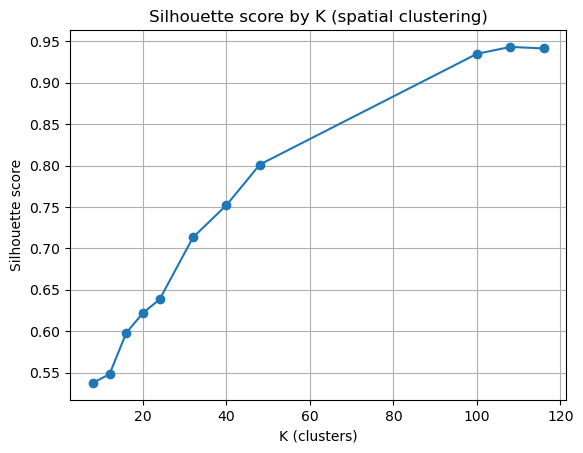


Chosen K (hotspots): 108


In [14]:
# Check the model clustering
plot_silhouette(sil_scores)
print(f"\nChosen K (hotspots): {k_best}")

We've automatically chosen the peak, which is 108 clusters. Everything is above 0.5 so we could back that off but let's see how it comes out.

Let's see what the top 10 risk score hotspots look like

In [10]:
top10 = hotspots.sort_values("risk_score", ascending=False).head(10)[
    ["cluster_id","nearest_line","risk_tier","risk_score","violent_share","total_incidents","inc_365d","inc_90d","inc_30d","lat","lon"]
]
display(HTML("<h3>Top 10 CTA Hotspots (clustered by location)</h3>"))
display(top10)

,cluster_id,nearest_line,risk_tier,risk_score,violent_share,total_incidents,inc_365d,inc_90d,inc_30d,lat,lon
54,54,MULTIPLE,Q5 (highest),0.829379,0.251426,1893.2,85.2,30.0,9.2,41.885738,-87.631492
30,30,MULTIPLE,Q5 (highest),0.647896,0.281442,1531.4,76.6,18.0,5.6,41.885577,-87.627949
2,2,RED,Q5 (highest),0.645690,0.357019,1733.8,57.8,16.8,5.4,41.750910,-87.625139
29,29,RED,Q5 (highest),0.537091,0.200395,2026.0,28.2,10.6,2.6,41.896868,-87.628198
23,23,RED,Q5 (highest),0.529980,0.579670,728.0,54.2,21.0,6.8,41.779977,-87.630935
9,9,MULTIPLE,Q5 (highest),0.483225,0.356249,1198.6,48.4,11.2,4.4,41.867364,-87.626588
26,26,RED,Q5 (highest),0.462824,0.463768,828.0,45.0,15.0,6.0,41.852874,-87.630924
59,59,MULTIPLE,Q5 (highest),0.434973,0.466296,1044.4,37.4,13.2,1.6,41.939913,-87.653291
76,76,RED,Q5 (highest),0.426046,0.384178,1054.2,42.6,8.6,3.6,41.878622,-87.627677
17,17,MULTIPLE,Q5 (highest),0.400626,0.548492,676.4,52.0,9.0,2.2,42.018510,-87.672993


In [11]:
#per line
display(HTML("<h3>Line-level summary</h3>"))
display(line_summary)

,nearest_line,hotspots,total_incidents,mean_risk,top_tier_share
6,RED,24,14183.6,0.268761,0.500000
3,MULTIPLE,20,9374.6,0.238406,0.350000
0,BLUE,17,4877.4,0.159344,0.176471
5,PINK,9,883.4,0.127326,0.000000
2,GREEN,21,4101.8,0.121683,0.000000
4,ORANGE,6,845.0,0.109545,0.000000
1,BROWN,11,828.2,0.105050,0.000000


Let's map this out and see where they tend to land

In [12]:
# use folium to display map inline
fmap = build_hotspot_map(hotspots)
display(HTML(fmap._repr_html_()))


Now let's update the model to account for ridership levels. This will allow us to look at incidence rates and more. We'll focus in on the last 12 months since it will help us build the strongest recommendations based on the current situation.

In [16]:
# get ridership df
rid = ridership_by_line_month.copy()
# Build month_start date for temporal alignment
rid["month_start"] = pd.to_datetime(dict(year=rid["year"], month=rid["month"], day=1), errors="coerce")


In [52]:
# Define analysis window:
end_date = df["date"].max().normalize()
start_date = end_date - pd.Timedelta(days=365)  # last 12 months

In [55]:
def get_sorted_rank(rid, start_date, end_date, window_label):
    # Filter ridership to window
    rid_win = rid[(rid["month_start"] >= start_date) & (rid["month_start"] <= end_date)].copy()
    
    # Incidents by line in window (weighted)
    if window_label == "last_12_months" and "inc_365d" in hotspots.columns:
        inc_by_line = hotspots.groupby("nearest_line")["inc_365d"].sum().rename("incidents_win").reset_index()
    else:
        inc_by_line = hotspots.groupby("nearest_line")["total_incidents"].sum().rename("incidents_win").reset_index()
    
    # Ridership exposure by line in window
    rides_by_line = rid_win.groupby("line")["rides"].sum().rename("rides_win").reset_index()
    
    # Join
    line_exposure = inc_by_line.merge(rides_by_line, left_on="nearest_line", right_on="line", how="left")
    line_exposure["rides_win"] = line_exposure["rides_win"].fillna(0.0)
    # Compute incidents per million rides
    line_exposure["inc_per_million_rides"] = np.where(
        line_exposure["rides_win"] > 0,
        (line_exposure["incidents_win"] / line_exposure["rides_win"]) * 1_000_000.0,
        np.nan
    )
    # Merge with original raw summary to compare
    compare = line_summary.merge(
        line_exposure.drop(columns=["line"]),
        on="nearest_line",
        how="left"
    )
    # Ranks
    compare["raw_rank"] = compare["mean_risk"].rank(method="min", ascending=False).astype(int)
    compare["rate_rank"] = compare["inc_per_million_rides"].rank(method="min", ascending=False).astype(int)
    compare["rank_change"] = compare["raw_rank"] - compare["rate_rank"]  # + means "moves up" when throughput-adjusted
    
    # Sort by rate_rank (exposure-adjusted)
    compare_sorted = compare.sort_values(["rate_rank", "inc_per_million_rides"], ascending=[True, False])

    return compare_sorted

Okay, now let's see if this shifted the top hotspots

In [61]:
window_label = "last_12_months"
compare_sorted=get_sorted_rank(rid, start_date, end_date, window_label)
display(HTML(f"<h3>Line risk vs. throughput-adjusted risk ({window_label.replace('_',' ')})</h3>"))
cols = ["nearest_line","hotspots","total_incidents","mean_risk","raw_rank","incidents_win","rides_win","inc_per_million_rides","rate_rank","rank_change","top_tier_share"]
display(compare_sorted[cols])


,nearest_line,hotspots,total_incidents,mean_risk,raw_rank,incidents_win,rides_win,inc_per_million_rides,rate_rank,rank_change,top_tier_share
1,MULTIPLE,20,9374.6,0.238406,2,423.0,16926238.0,24.990786,1,1,0.350000
0,RED,24,14183.6,0.268761,1,494.2,19954806.0,24.765964,2,-1,0.500000
4,GREEN,21,4101.8,0.121683,5,87.8,5055041.0,17.368801,3,2,0.000000
6,BROWN,11,828.2,0.105050,7,59.2,3657211.0,16.187198,4,3,0.000000
3,PINK,9,883.4,0.127326,4,33.6,2388967.0,14.064656,5,-1,0.000000
5,ORANGE,6,845.0,0.109545,6,42.8,3467009.0,12.344935,6,0,0.000000
2,BLUE,17,4877.4,0.159344,3,158.2,17808486.0,8.883405,7,-4,0.176471


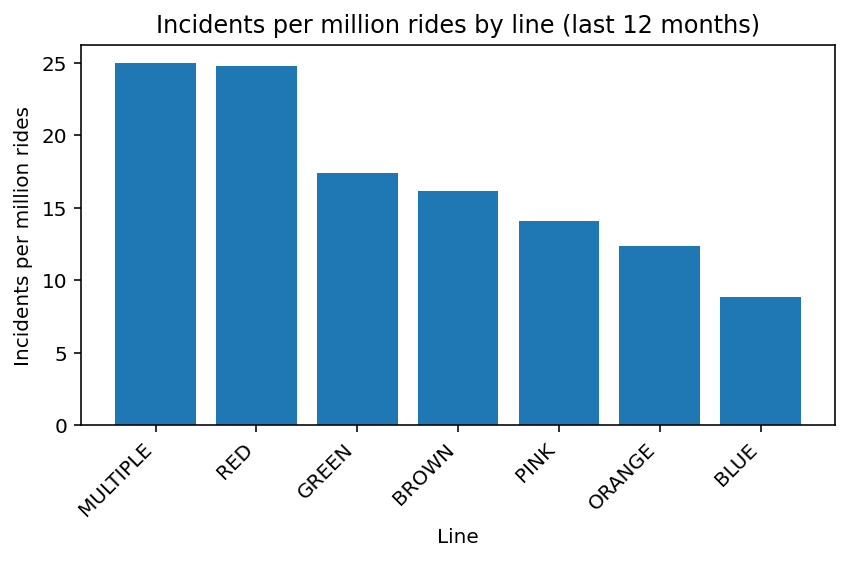

In [57]:
plt.figure()
bars = plt.bar(compare_sorted["nearest_line"].astype(str), compare_sorted["inc_per_million_rides"].values)
plt.title(f"Incidents per million rides by line ({window_label.replace('_',' ')})")
plt.xlabel("Line")
plt.ylabel("Incidents per million rides")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

So the biggest shift here is that the Blue line was a second tier risk level before accounting for ridership, but here we see that it is has the lowest incidience rate. The Green is back in its expected place, though still second to the Red line and the Loop area. The most surprising is that the Brown and Green line are almost tied for incidence. This is a pretty big shift from the Brown being considered the safest.

Let's look across history and see if those reputations were accurate.

In [83]:
window_label= "per year since 2001"
compare_sorted_all=get_sorted_rank(rid, start_date, end_date, window_label)
compare_sorted_all['inc_per_million_rides'] = compare_sorted_all["inc_per_million_rides"].values/24.7

In [93]:

display(HTML(f"<h3>Line risk vs. throughput-adjusted risk ({window_label.replace('_',' ')})</h3>"))
cols = ["nearest_line","hotspots","total_incidents","mean_risk","raw_rank","incidents_win","rides_win","inc_per_million_rides","rate_rank","rank_change","top_tier_share"]
display(compare_sorted_all[cols])

,nearest_line,hotspots,total_incidents,mean_risk,raw_rank,incidents_win,rides_win,inc_per_million_rides,rate_rank,rank_change,top_tier_share
4,GREEN,21,4101.8,0.121683,5,4101.8,5055041.0,32.851322,1,4,0.000000
0,RED,24,14183.6,0.268761,1,14183.6,19954806.0,28.776768,2,-1,0.500000
1,MULTIPLE,20,9374.6,0.238406,2,9374.6,16926238.0,22.423084,3,-1,0.350000
3,PINK,9,883.4,0.127326,4,883.4,2388967.0,14.970982,4,0,0.000000
2,BLUE,17,4877.4,0.159344,3,4877.4,17808486.0,11.088286,5,-2,0.176471
5,ORANGE,6,845.0,0.109545,6,845.0,3467009.0,9.867447,6,0,0.000000
6,BROWN,11,828.2,0.105050,7,828.2,3657211.0,9.168288,7,0,0.000000


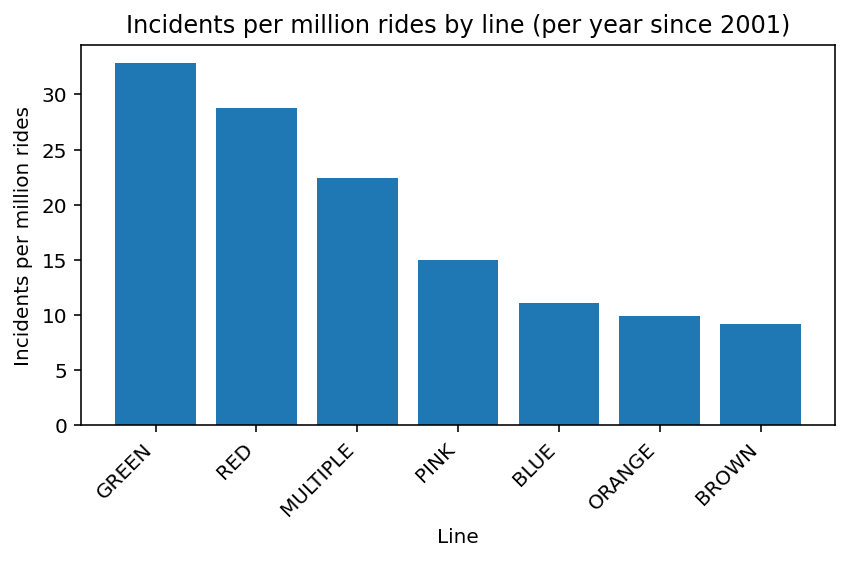

In [84]:

plt.figure()
bars = plt.bar(compare_sorted_all["nearest_line"].astype(str), compare_sorted_all["inc_per_million_rides"].values)
plt.title(f"Incidents per million rides by line ({window_label.replace('_',' ')})")
plt.xlabel("Line")
plt.ylabel("Incidents per million rides")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [89]:
long = pd.concat([
        compare_sorted_all[['nearest_line', 'inc_per_million_rides']].assign(series='historical'),
        compare_sorted[['nearest_line', 'inc_per_million_rides']].assign(series='2025'),
    ], ignore_index=True)

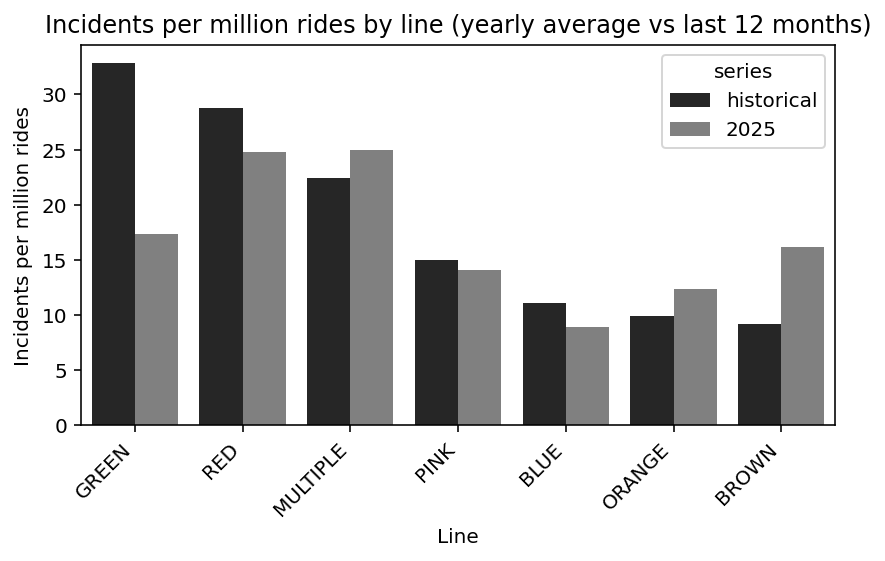

In [94]:
import seaborn as sns
sns.barplot(data=long,x='nearest_line',y='inc_per_million_rides',hue='series', palette='dark:grey')
plt.title(f"Incidents per million rides by line (yearly average vs last 12 months)")
plt.xlabel("Line")
plt.ylabel("Incidents per million rides")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()